In [1]:
from torch.utils.data import DataLoader, TensorDataset

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


train_batch = {}
test_batch = unpickle('/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch')
for i in range(5):
    train_batch[f'batch_{i+1}'] = unpickle("/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_%d"%(i + 1))


def get_dataset(batch_dict,test_dict):


    training_image = torch.tensor(torch.cat((torch.tensor(batch_dict['batch_1'][b'data']),torch.tensor(batch_dict['batch_2'][b'data']),torch.tensor(batch_dict['batch_3'][b'data']),torch.tensor(batch_dict['batch_4'][b'data']),torch.tensor(batch_dict['batch_5'][b'data'])),0),dtype = torch.float32)
    training_labels = torch.tensor(torch.cat((torch.tensor(batch_dict['batch_1'][b'labels']),torch.tensor(batch_dict['batch_2'][b'labels']),torch.tensor(batch_dict['batch_3'][b'labels']),torch.tensor(batch_dict['batch_4'][b'labels']),torch.tensor(batch_dict['batch_5'][b'labels']))))     

    test_images = torch.tensor(test_dict[b'data'],dtype = torch.float32)
    test_labels = torch.tensor(test_dict[b'labels'])

    training_image = training_image.view(50000,3,32,32)
    test_images = test_images.view(test_images.shape[0],3,32,32)

    return training_image,training_labels,test_images,test_labels


def make_batches(batch_size=16):
    training_image,training_labels,test_images,test_labels = get_dataset(train_batch,test_batch)
    train_dataset = TensorDataset(training_image,training_labels)
    test_dataset = TensorDataset(test_images,test_labels)
    train_loader = DataLoader(train_dataset,shuffle=True,batch_size=batch_size)
    test_loader = DataLoader(test_dataset,shuffle =True,batch_size=batch_size)

    return train_loader,test_loader




In [2]:
import torch.nn as nn
import torch 
import torch.nn.functional as F 

In [3]:
import torch 
import torch.nn as nn
def training(model,criterion,optimizer,train_loader,epochs=10,device='cuda'):
    training_loss = 0.0
    training_accuracy = 0
    for epoch in range(epochs):
        for i,(images,labels) in enumerate(train_loader):
            images= images.to(device)
            labels = labels.to(device)
            output = model(images)

            loss = criterion(output,labels)

            # training_loss += loss.item()
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            _, predicted = torch.max(output.data, 1)

            training_accuracy += (predicted == labels).sum().item()
            if ((i+1)%100 == 0):
                print(f'epoch:{epoch + 1},loss:{loss.item():.4f}')
        print(f'accuracy:{training_accuracy*100/50000}')
        training_accuracy = 0    

#     torch.save(model.state_dict(),'/kaggle/working/model.pth')

    return model


def evaluation(model,test_loader,device='cuda'):
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        test_loss = 0.0
        test_accuracy = 0
        for i,(images, labels) in enumerate(test_loader):
            images= images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            
        acc = 100.0 * n_correct / n_samples
        
        print(f'Accuracy of the network on the 10000 test images: {acc} %')

In [4]:
class ResidualBlock(nn.Module):
    
    def __init__(self,input_channels,no_of_filters,kernel_size=3,stride1 = 1,stride2 = 1,padding = 1):
        
        super(ResidualBlock,self).__init__()
        
        self.resblock = nn.Sequential(nn.Conv2d(input_channels,no_of_filters,kernel_size = kernel_size,stride = stride1,padding = padding),
                                      nn.BatchNorm2d(no_of_filters),
                                      nn.ReLU(),
                                      nn.Conv2d(no_of_filters,no_of_filters,kernel_size = kernel_size,stride = stride2,padding = padding),
                                      nn.BatchNorm2d(no_of_filters),
                                      nn.ReLU()
                                     )
    def forward(self,x):
        
        x = self.resblock(x)
        return x 
    
    
class IdentityBlock(nn.Module):
    
        def __init__(self,input_channels,no_of_filters,kernel_size=3,stride = 1 ,padding = 0):
            
            super(IdentityBlock,self).__init__()
            
            self.idblock = nn.Sequential(nn.Conv2d(input_channels,no_of_filters,kernel_size = kernel_size,stride = stride,padding = padding),
                                          nn.BatchNorm2d(no_of_filters),
                                          nn.ReLU()
                                         )
        def forward(self,x):
        
            x = self.idblock(x)
            return x 
            

In [5]:
class Resnet18(nn.Module):
    
    def __init__(self):
        super(Resnet18,self).__init__()
        
        self.block1_0 = nn.Conv2d(3,64,3,padding = 1) 
        
        self.block1_1 = ResidualBlock(64,64,kernel_size = 3)                                             
        self.block1_2 = ResidualBlock(64,64,kernel_size = 3)                                             
        
        self.block2_0 = IdentityBlock(64,128,kernel_size =1 ,stride =2)                  
        self.block2_1 = ResidualBlock(64,128,stride1=2,stride2=1)                                                
        
        self.block3_0 = ResidualBlock(128,128,stride1=1,stride2=1)
        
        self.block4_0 = IdentityBlock(128,256,kernel_size =1 ,stride =2)
        self.block4_1 = ResidualBlock(128,256,stride1=2,stride2=1)

        self.block5_0 = ResidualBlock(256,256,stride1=1,stride2=1)
        
        self.block6_0 = IdentityBlock(256,512,kernel_size =1 ,stride =2)
        self.block6_1 = ResidualBlock(256,512,stride1=2,stride2=1)
        
        self.block7_0 = ResidualBlock(512,512,stride1=1,stride2=1)
        
        self.fc1 = nn.Linear(512*4*4,512)
        self.fc2 = nn.Linear(512,10)
        
        self.bnorm = nn.BatchNorm1d(512)

        
        
    def forward(self,x):
        
        x = self.block1_0(x)
        
        shortcut = x
        x = self.block1_1(x)
        x = x + shortcut
        
        shortcut = x
        x = self.block1_2(x)
        x = x + shortcut
        

        
        shortcut = x
        x = self.block2_1(x)
        shortcut = self.block2_0(shortcut) 
        x = x + shortcut

        
        shortcut = x 
        x = self.block3_0(x)
        x = x + shortcut
        
        shortcut = x
        shortcut = self.block4_0(shortcut)
        x = self.block4_1(x)
        x = x + shortcut



        shortcut = x 
        x = self.block5_0(x)
        x = x + shortcut
        
        
        shortcut = x
        shortcut = self.block6_0(shortcut)
        x = self.block6_1(x)
        x = x + shortcut
        
        shortcut = x 
        x = self.block7_0(x)
        x = x + shortcut
        
        
        x = x.view(x.shape[0],512*4*4)
        
        x = self.fc1(x)
        x = F.relu(self.bnorm(x))
        
        x = self.fc2(x)
        return x
        
        

        
        
        


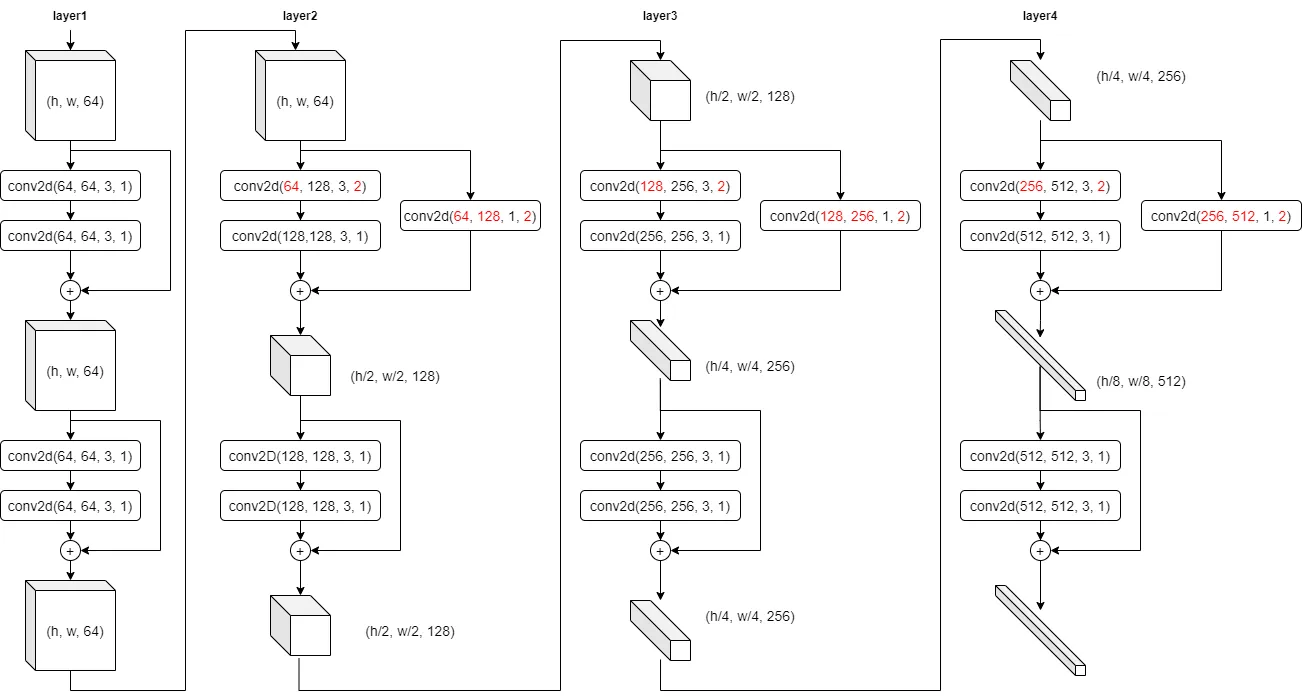

In [6]:
resnet = Resnet18()

In [7]:
device = 'cuda'
resnet.to(device)

Resnet18(
  (block1_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block1_1): ResidualBlock(
    (resblock): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (block1_2): ResidualBlock(
    (resblock): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (block2_0): IdentityBlock(
    

In [8]:
train_loader,test_loader = make_batches(128)

/tmp/ipykernel_26/4082462149.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_image = torch.tensor(torch.cat((torch.tensor(batch_dict['batch_1'][b'data']),torch.tensor(batch_dict['batch_2'][b'data']),torch.tensor(batch_dict['batch_3'][b'data']),torch.tensor(batch_dict['batch_4'][b'data']),torch.tensor(batch_dict['batch_5'][b'data'])),0),dtype = torch.float32)
/tmp/ipykernel_26/4082462149.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_labels = torch.tensor(torch.cat((torch.tensor(batch_dict['batch_1'][b'labels']),torch.tensor(batch_dict['batch_2'][b'labels']),torch.tensor(batch_dict['batch_3'][b'labels']),torch.tensor(batch_dict['batch_4'][b'labels']),torch.ten

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(resnet.parameters(),lr = 0.001)

In [10]:
new_model =  training(resnet,criterion,optimizer,train_loader,epochs = 15)

epoch:1,loss:1.3601
epoch:1,loss:1.2003
epoch:1,loss:0.9814
accuracy:55.612
epoch:2,loss:0.7329
epoch:2,loss:0.6933
epoch:2,loss:0.6955
accuracy:74.344
epoch:3,loss:0.3642
epoch:3,loss:0.5130
epoch:3,loss:0.5846
accuracy:81.642
epoch:4,loss:0.4451
epoch:4,loss:0.2829
epoch:4,loss:0.4686
accuracy:86.99
epoch:5,loss:0.2462
epoch:5,loss:0.2471
epoch:5,loss:0.2375
accuracy:91.3
epoch:6,loss:0.1463
epoch:6,loss:0.1414
epoch:6,loss:0.2542
accuracy:94.332
epoch:7,loss:0.1143
epoch:7,loss:0.1031
epoch:7,loss:0.1319
accuracy:96.606
epoch:8,loss:0.0264
epoch:8,loss:0.0876
epoch:8,loss:0.1605
accuracy:97.532
epoch:9,loss:0.0644
epoch:9,loss:0.0741
epoch:9,loss:0.0963
accuracy:97.752
epoch:10,loss:0.0367
epoch:10,loss:0.1283
epoch:10,loss:0.0811
accuracy:97.984
epoch:11,loss:0.0169
epoch:11,loss:0.0525
epoch:11,loss:0.0451
accuracy:98.222
epoch:12,loss:0.0501
epoch:12,loss:0.0177
epoch:12,loss:0.0383
accuracy:98.606
epoch:13,loss:0.0341
epoch:13,loss:0.0347
epoch:13,loss:0.1746
accuracy:98.424
epo

In [11]:
evaluation(resnet,test_loader)

Accuracy of the network on the 10000 test images: 81.89 %
